In [1]:
# http://efavdb.com/predicting-san-francisco-crimes/
# https://github.com/lenguyenthedat/kaggle-for-fun/tree/master/sf-crime-classification
# PREDICT PROBA
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
#from sklearn import metrics
from sklearn import preprocessing

# Machine Learning imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import learning_curve
from sklearn import grid_search
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV


%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv('../../../data_sfpd/train.csv', parse_dates = ['Dates'])
test = pd.read_csv('../../../data_sfpd/test.csv', parse_dates = ['Dates'])

AttributeError: 'tuple' object has no attribute 'split'

In [34]:
train['Address']

0                    OAK ST / LAGUNA ST
1                    OAK ST / LAGUNA ST
2             VANNESS AV / GREENWICH ST
3              1500 Block of LOMBARD ST
4             100 Block of BRODERICK ST
5                   0 Block of TEDDY AV
6                   AVALON AV / PERU AV
7              KIRKWOOD AV / DONAHUE ST
8                  600 Block of 47TH AV
9         JEFFERSON ST / LEAVENWORTH ST
10        JEFFERSON ST / LEAVENWORTH ST
11                0 Block of ESCOLTA WY
12                   TURK ST / JONES ST
13               FILLMORE ST / GEARY BL
14             200 Block of WILLIAMS AV
15                0 Block of MENDELL ST
16                   EDDY ST / JONES ST
17               GODEUS ST / MISSION ST
18               MENDELL ST / HUDSON AV
19                100 Block of JONES ST
20               200 Block of EVELYN WY
21            1600 Block of VALENCIA ST
22                100 Block of JONES ST
23                100 Block of JONES ST
24             FILLMORE ST / LOMBARD ST


In [4]:
train['Address'].str.split(' ')

0                    [OAK, ST, /, LAGUNA, ST]
1                    [OAK, ST, /, LAGUNA, ST]
2             [VANNESS, AV, /, GREENWICH, ST]
3              [1500, Block, of, LOMBARD, ST]
4             [100, Block, of, BRODERICK, ST]
5                   [0, Block, of, TEDDY, AV]
6                   [AVALON, AV, /, PERU, AV]
7              [KIRKWOOD, AV, /, DONAHUE, ST]
8                  [600, Block, of, 47TH, AV]
9         [JEFFERSON, ST, /, LEAVENWORTH, ST]
10        [JEFFERSON, ST, /, LEAVENWORTH, ST]
11                [0, Block, of, ESCOLTA, WY]
12                   [TURK, ST, /, JONES, ST]
13               [FILLMORE, ST, /, GEARY, BL]
14             [200, Block, of, WILLIAMS, AV]
15                [0, Block, of, MENDELL, ST]
16                   [EDDY, ST, /, JONES, ST]
17               [GODEUS, ST, /, MISSION, ST]
18               [MENDELL, ST, /, HUDSON, AV]
19                [100, Block, of, JONES, ST]
20               [200, Block, of, EVELYN, WY]
21            [1600, Block, of, VA

In [43]:
street = train['Address'].str.replace('[0-9]* Block of | ST| AV| BL', '', case=False)

In [49]:
street_clean = street.str.split('/')

In [68]:
train['Intersection'] = train['Address'].str.find('/')
test['Intersection'] = test['Address'].str.find('/')

In [58]:
list(train)

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Intersection']

In [69]:
train['Intersection'][train['Intersection'] != -1] = 1
train['Intersection'][train['Intersection'] == -1] = 0
test['Intersection'][test['Intersection'] != -1] = 1
test['Intersection'][test['Intersection'] == -1] = 0

In [70]:
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Intersection
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1


In [71]:
list(train)

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Intersection']

In [72]:
# data clean up
train = train.drop(train['X'] > 40, axis=0)

In [10]:
category_count = train['Category'].value_counts()

In [11]:
remove_category = (category_count.keys())[-6::]

In [12]:
for i in remove_category:
    print(i, (train['Category']==i).sum())
    train = train[train['Category'] != i]

BRIBERY 289
EXTORTION 256
SEX OFFENSES NON FORCIBLE 148
GAMBLING 146
PORNOGRAPHY/OBSCENE MAT 22
TREA 6


In [73]:
X = train.drop(['Category'], axis=1) 
crime = preprocessing.LabelEncoder()
y = crime.fit_transform(train['Category'])

In [77]:
# create dummies
def create_dummies(data):
    days = pd.get_dummies(data.DayOfWeek)
    district = pd.get_dummies(data.PdDistrict)
    hour = data.Dates.dt.hour
    data['Morning'] = (hour>= 6) & (hour < 12)
    data['Afternoon'] = (hour >= 12) & (hour < 18)
    data['Evening'] = (hour >= 18) & (hour < 24)
    data['Night'] = (hour < 6)
    days = pd.get_dummies(data.DayOfWeek)
    district = pd.get_dummies(data.PdDistrict)
    return pd.concat([data['Morning'], data['Afternoon'], data['Evening'], 
                       data['Night'], data['X'], data['Y'], days, data['Intersection'], district],
                       axis=1)

In [78]:
X_clean = create_dummies(X)
test_clean = create_dummies(test)

In [ ]:
# Logistic Regression
pipe = Pipeline([
    ('log', LogisticRegression(probability=True)),
])
param = {
    'log__C': np.logspace(-3, 3, 3),
}

In [55]:
# Support Vector Machine
pipe = Pipeline([
    ('svc', SVC(probability=True)),  #SVC(probability=True)
])
param = {
    #'svc__degree': np.arange(1, 5),
    'svc__C': np.logspace(-3, 0, 2),
    #'svc__gamma': np.logspace(-3, 3, 10),
}


In [37]:
# Random Forest
pipe = Pipeline([
    ('rf', RandomForestClassifier()),
])
param = {
    #'rf__min_samples_split': np.arange(2, 5),
    'rf__min_samples_leaf': np.arange(40, 70, 10),
    #'rf__n_estimators': np.arange(10, 200, 10),
    #'rf__max_leaf_nodes': np.arange(10, 20),
    #'rf__max_features': ('sqrt', 'auto'),
}

In [79]:
# Naive Bayesian
from sklearn.naive_bayes import BernoulliNB
pipe = Pipeline([
    ('bnb', BernoulliNB()),
])
param = {
    'bnb__alpha': np.linspace(0, 1, 10),
}

In [ ]:
grid_search = GridSearchCV(pipe, param, n_jobs=-2, verbose=3,
                           cv=5, refit=True)
print("\nPerforming grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
grid_search.fit(X_clean, y);
print("\nBest score: {:0.3f}".format(grid_search.best_score_))
print("\nBest parameters set:")
best_param = grid_search.best_estimator_.get_params()
for param_name in sorted(param.keys()):
    print("\t{}: {}".format(param_name, best_param[param_name]))
print('TEST set')
y_pred = grid_search.best_estimator_.predict(X_clean)
y_proba = grid_search.best_estimator_.predict_proba(X_clean)
print(metrics.accuracy_score(y, y_pred))
print(y[:5])
print(y_pred[:5])
print(log_loss(y, y_proba))
# 2.2791946 rf__min_samples_leaf: 50


Performing grid search...
pipeline: ['bnb']
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[Parallel(n_jobs=-2)]: Done   1 jobs       | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  32 jobs       | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done  46 out of  50 | elapsed:  1.7min remaining:    8.7s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  1.7min finished




Best score: 0.227

Best parameters set:
	bnb__alpha: 0.1111111111111111

In [26]:
test = pd.read_csv('../../../data_sfpd/test.csv', parse_dates = ['Dates'])

In [28]:
crime = preprocessing.LabelEncoder()
y_test = crime.fit_transform(train['Category'])

In [39]:
test_proba = grid_search.best_estimator_.predict_proba(test_clean)

In [41]:
result=pd.DataFrame(test_proba, columns=crime.classes_)
result.to_csv('../../../data_sfpd/result.csv', index = True, index_label = 'Id' )

In [133]:
P = lrm.predict_proba(X_new)

In [112]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, criterion='entropy')
clf = clf.fit(X_new, y)
class_forest = clf.predict(X_new)
print(class_forest)
print(accuracy_score(class_forest, y))

[ 0  0  0 ..., 38 38 38]
0.935168738899


In [113]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, criterion='gini')
clf = clf.fit(X_new, y)
class_forest = clf.predict(X_new)
print(class_forest)
print(accuracy_score(class_forest, y))

[21  0  0 ..., 38 38 38]
0.934321007589


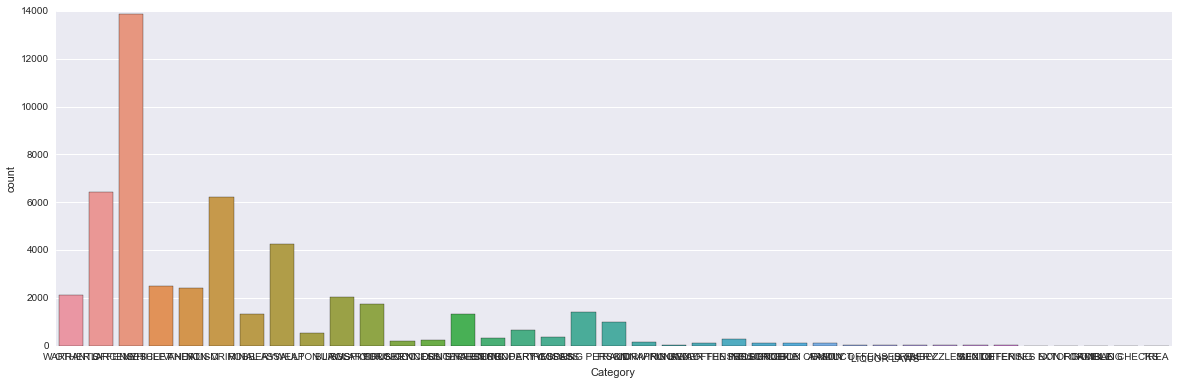

In [44]:
plt.figure(figsize=(20, 6))
sns.countplot(y='Category', data=train)
# split

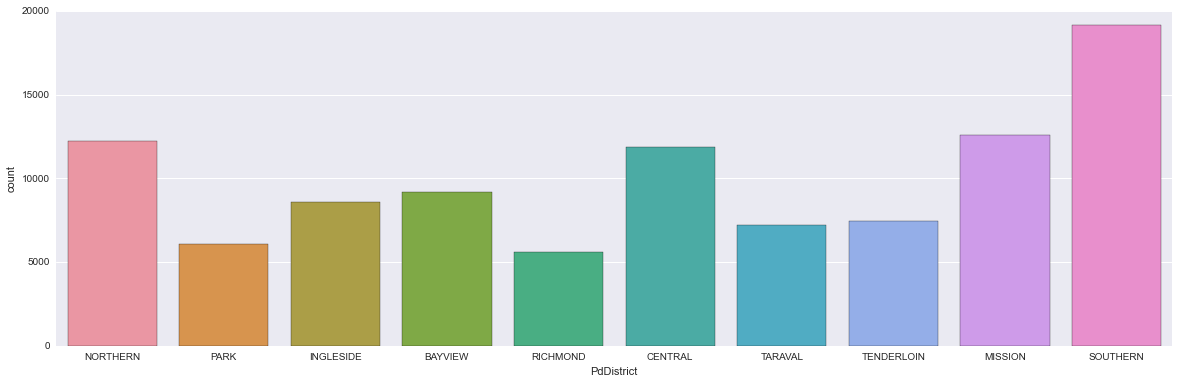

In [116]:
plt.figure(figsize=(20, 6))
sns.countplot(y='PdDistrict', data=train)

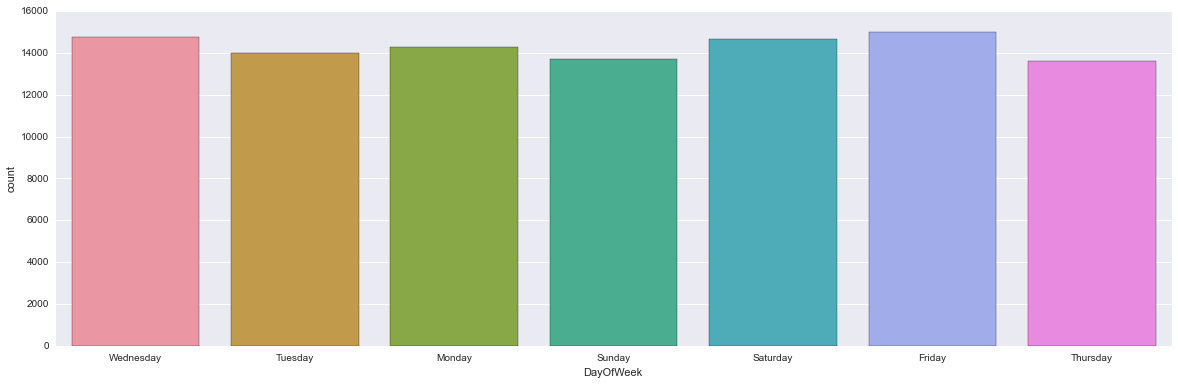

In [117]:
plt.figure(figsize=(20, 6))
sns.countplot('DayOfWeek', data=train)

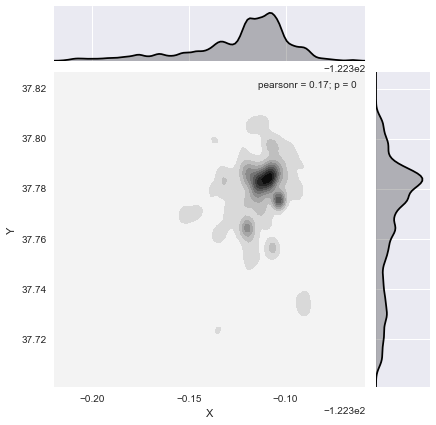

In [120]:
sns.jointplot(x=train['X'], y=train['Y'], kind="kde", color="k")